# 05__validation

in this notebook, i compare our screen results to individual validations performed on 22 sgRNAs.

figures in this notebook:
- Fig 4A: scatter plot showing the comparison between screen results and individual validation results
- Fig 4B: RT-qPCR results for a subset of mRNAs
- Fig 4C: RT-qPCR results for a subset of lncRNAs

tables in this notebook:
- Table S4: validation results + screen results for these validated sgRNAs

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import sys
import time

from ast import literal_eval
from os import walk
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
data_f = "../../../data/02__screen/02__enrichment_data/SuppTable_S2.sgRNA_results.txt"

In [4]:
crisphie_f = "../../../data/02__screen/02__enrichment_data/SuppTable_S3.CRISPhieRmix_results.txt"

In [5]:
validation_data_f = "../../../data/02__screen/03__validation_data/validation_data.xlsx"

In [6]:
qpcr_dir = "../../../data/02__screen/03__validation_data/rt_qpcr_data"

## 1. import data

In [7]:
data = pd.read_table(data_f, sep="\t")
data.head()

,sgRNA,control_status,gene_name,gene_id,transcript_name,transcript_id,tss_id,tss_chr_hg38,tss_start_hg38,tss_strand_hg38,...,DayZero_Rep2__cpm,Undiff_Rep1__cpm,Undiff_Rep2__cpm,Diff_Rep1__cpm,Diff_Rep2__cpm,sgRNA_status,sgRNA_l2fc_diff,sgRNA_l2fcSE_diff,sgRNA_l2fc_dz,sgRNA_l2fcSE_dz
0,TTGCAAGTGTCTTTAAACTA,experimental,RP4-714D9.2,ENSG00000241073.1_2,RP4-714D9.2-001,ENST00000432294.1_1,NC_000001.11:-:100084320,chr1,100084320,-,...,9.515495,5.975173,7.449968,2.683950,7.813446,filter not met,0.698721,0.818113,0.737236,0.214448
1,ATTGCAAGTGTCTTTAAACT,experimental,RP4-714D9.2,ENSG00000241073.1_2,RP4-714D9.2-001,ENST00000432294.1_1,NC_000001.11:-:100084320,chr1,100084320,-,...,4.041303,0.006844,3.192843,5.414577,4.901161,filter not met,-6.009609,1.845461,-0.545334,0.218948
2,AGCCAGTATCTTGAAACTAT,experimental,RP4-714D9.2,ENSG00000241073.1_2,RP4-714D9.2-001,ENST00000432294.1_1,NC_000001.11:-:100084320,chr1,100084320,-,...,6.378442,0.006844,7.669919,4.518371,7.113280,filter not met,-5.394790,1.803385,0.020249,0.205027
3,TGCCAATAGTTTCAAGATAC,experimental,RP4-714D9.2,ENSG00000241073.1_2,RP4-714D9.2-001,ENST00000432294.1_1,NC_000001.11:-:100084320,chr1,100084320,-,...,3.665691,3.538562,4.150696,5.349229,3.886428,filter not met,-0.095650,0.947994,-0.465902,0.225919
4,ACAGTAGTGTATCTAAATGG,experimental,RP4-714D9.2,ENSG00000241073.1_2,RP4-714D9.2-001,ENST00000432294.1_1,NC_000001.11:-:100084320,chr1,100084320,-,...,8.200854,0.006844,4.902788,10.567761,6.900186,filter not met,-6.284486,1.797577,-0.075382,0.192657


In [8]:
val_data = pd.read_excel(validation_data_f)
print(len(val_data))
val_data.head()

24


,gene_name,guide_num,guide_sequence,guide_undiff,scram_undiff,guide_diff,scram_diff,rtqpcr_kd_level,date_facs,date_rtqpcr
0,ACVR2B-AS1,8,TAGAGGCGCCCCTGCGATGG,24.49,1.53,11.74,62.30,0.55,190906,190906
1,ACVR2B-AS1,6,TAGCCCGAACTCCGACCCTG,38.75,1.53,6.24,62.30,0.51,190906,190906
2,DIGIT,8,AAATCAGGCGGTGAGTACGT,23.99,1.82,23.63,59.22,0.10,190816,190829
3,EOMES,10,CGCGGGCTAGTGGGTGGATG,9.68,1.65,45.46,61.37,0.50,190508,190726
4,EOMES,1,TTTGCAAAGCATGCAGTTAG,39.81,1.65,22.27,61.37,0.21,190508,190709


In [9]:
crisphie = pd.read_table(crisphie_f, sep="\t")
print(len(crisphie))
crisphie.head()

9771


,group_id,transcript_name,ctrl_status,transcript_biotype_status,CRISPhieRmix_FDR,effect_size,hit_status,n_sgRNA
0,NC_000003.12:-:27722707,EOMES-004,control,protein_coding,0.0,6.092888,hit,6
1,NC_000019.10:+:11060127,SMARCA4-014,mRNA,protein_coding,0.0,1.145824,hit,6
2,NC_000023.11:-:11111137,"[RP11-120D5.1-005, RP11-120D5.1-004]",experimental,promoter_overlap,0.0,4.142174,hit,7
3,NC_000020.11:+:37095770,RP4-621N11.2-001,experimental,promoter_overlap,0.0,0.626713,hit,5
4,NC_000011.10:+:90223166,RP11-121L10.2-001,experimental,promoter_overlap,0.0,5.297966,hit,8


In [10]:
crisphie.hit_status.value_counts()

no hit    9698
hit         73
Name: hit_status, dtype: int64

In [11]:
files = []
for (dirpath, dirnames, filenames) in walk(qpcr_dir):
    files.extend(filenames)
    break
print(len(files))
files

24


['pvt1__sgrna__2.txt',
 'rp11-222k16.2__sgrna__3.txt',
 'rp11-120d5.1__sgrna__2.txt',
 'rp3-508i15.9__sgrna__2.txt',
 'rp11-120d5.1__sgrna__1.txt',
 'eomes__sgrna__1.txt',
 'acvr2b-as1__sgrna__8.txt',
 'acvr2b-as1__sgrna__6.txt',
 'eomes__sgrna__10.txt',
 'kb-1440d3.14__sgrna__9.txt',
 'pvt1__sgrna__6.txt',
 'foxa2__sgrna__5.txt',
 'rp11-23f23.2__sgrna__6.txt',
 'rp11-222k16.2__sgrna__9.txt',
 'linc00479__sgrna__3.txt',
 'digit__sgrna__8.txt',
 'sox17__sgrna__4.txt',
 'rp3-508i15.9__sgrna__1.txt',
 'gata6__sgrna__5.txt',
 'sox17__sgrna__1.txt',
 'foxa2__sgrna__1.txt',
 'gata6__sgrna__1.txt',
 'pvt1__sgrna__9.txt',
 'pvt1__sgrna__1.txt']

## 2. merge validation data w/ screen data

In [12]:
data_sub = data[["sgRNA", "sgRNA_l2fc_diff", "tss_id"]]

In [13]:
val_data = val_data.merge(data_sub, left_on="guide_sequence", right_on="sgRNA", how="left")

In [14]:
val_data = val_data.merge(crisphie[["group_id", "transcript_biotype_status", "hit_status"]], 
                          left_on="tss_id", right_on="group_id", how="left")
val_data.drop(["sgRNA", "group_id"], axis=1, inplace=True)

## 3. calculate validation data "enrichment" (guide enrichment normalized by scrambled enrichment)

In [15]:
val_data["guide_undiff_enrich"] = val_data["guide_undiff"]/val_data["guide_diff"]
val_data["scram_undiff_enrich"] = val_data["scram_undiff"]/val_data["scram_diff"]
val_data["val_score"] = np.log2(val_data["guide_undiff_enrich"]/val_data["scram_undiff_enrich"])

In [16]:
# remove the 2 sgRNAs that weren't in the screen
val_data = val_data[~pd.isnull(val_data["hit_status"])]

## 4. plot correlation -- all validated sgRNAs

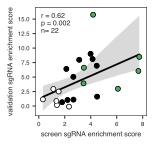

In [17]:
fig = plt.figure(figsize=(2, 2))
ax = sns.regplot(data=val_data, x="sgRNA_l2fc_diff", y="val_score", color="black")

hits = val_data[val_data["hit_status"] == "hit"]
nonhits = val_data[val_data["hit_status"] == "no hit"]

pc_hits = hits[hits["transcript_biotype_status"] == "protein_coding"]
pc_nonhits = nonhits[nonhits["transcript_biotype_status"] == "protein_coding"]

lnc_hits = hits[hits["transcript_biotype_status"] != "protein_coding"]
lnc_nonhits = nonhits[nonhits["transcript_biotype_status"] != "protein_coding"]

ax.scatter(pc_hits["sgRNA_l2fc_diff"], pc_hits["val_score"], color=sns.color_palette()[2], zorder=11,
           edgecolors="black", linewidth=0.5)
ax.scatter(pc_nonhits["sgRNA_l2fc_diff"], pc_nonhits["val_score"], color="white", 
           edgecolors=sns.color_palette()[2], linewidth=0.5, zorder=11)

ax.scatter(lnc_hits["sgRNA_l2fc_diff"], lnc_hits["val_score"], color="black", zorder=11)
ax.scatter(lnc_nonhits["sgRNA_l2fc_diff"], lnc_nonhits["val_score"], color="white", 
           edgecolors="black", linewidth=0.5, zorder=11)

ax.set_xlabel("screen sgRNA enrichment score")
ax.set_ylabel("validation sgRNA enrichment score")

no_nan = val_data[~pd.isnull(val_data["sgRNA_l2fc_diff"])]
r, p = stats.spearmanr(no_nan["sgRNA_l2fc_diff"], no_nan["val_score"])
ax.text(0.05, 0.95, "r = %s\np = %s\nn= %s" % ((round(r, 2), round(p, 4), len(no_nan))), 
        ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)

fig.savefig("Fig4A.pdf", dpi="figure", bbox_inches="tight")

In [18]:
val_data[val_data["gene_name"] == "RP11-222K16.2"][["guide_num", "guide_sequence", "sgRNA_l2fc_diff", "val_score"]]

,guide_num,guide_sequence,sgRNA_l2fc_diff,val_score
17,3,TGTCTTGAAAAGAATGTCGG,1.793723,0.665811
18,9,GAGCTGTCGAAATCTCCGCG,2.670349,1.114676


## 5. load RT-qPCR data

In [19]:
def row_type(row):
    if "scrm" in row["variable"]:
        return "scramble"
    else:
        return "sgRNA"

In [20]:
qpcr_dict = {}

for f in files:
    n = f.split("__")[0]
    sgrna = f.split("__")[2].split(".")[0]
    df = pd.read_table("%s/%s" % (qpcr_dir, f))
    df.columns = ["gene", "scrm_val", "scrm_yerr1", "scrm_yerr2", "sgrna_val", "sgrna_yerr1", "sgrna_yerr2"]
    melt = pd.melt(df, id_vars=["gene"])
    melt["type"] = melt.apply(row_type, axis=1)
    qpcr_dict["%s__%s" % (n.upper(), sgrna)] = melt

In [21]:
qpcr_dict["SOX17__1"]

,gene,variable,value,type
0,SOX17,scrm_val,1.000000,scramble
1,SOX17,scrm_yerr1,0.030124,scramble
2,SOX17,scrm_yerr2,0.030124,scramble
3,SOX17,sgrna_val,0.071298,sgRNA
4,SOX17,sgrna_yerr1,0.006562,sgRNA
5,SOX17,sgrna_yerr2,0.006562,sgRNA


## 6. make RT-qPCR plots
for SOX17, EOMES, RP11-120D5.1, RP11-222K16.2 (figure 4)

In [22]:
genes = ["SOX17", "EOMES", "RP11-120D5.1", "RP11-222K16.2"]
plot_df = pd.DataFrame()

for key in qpcr_dict:
    gene = key.split("__")[0]
    if gene in genes:
        df = qpcr_dict[key]
        df["info"] = key
        plot_df = plot_df.append(df)

In [23]:
vals = plot_df[plot_df["variable"].str.contains("val")]
yerrs = plot_df[plot_df["variable"].str.contains("yerr1")]
print(len(vals))
print(len(yerrs))

16
16


In [24]:
order = ["SOX17__1", "SOX17__4", "EOMES__1", "EOMES__10"]
pal = {"scrm_val": "darkgray", "sgrna_val": sns.color_palette()[2]}

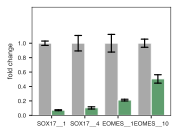

In [25]:
fig = plt.figure(figsize=(2.5, 2))

ax = sns.barplot(data=vals, x="info", y="value", hue="variable", order=order, palette=pal)
ax.set_xlabel("")
ax.set_ylabel("fold change")
ax.get_legend().remove()
ax.set_ylim((0, 1.5))
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

# plot errors
xs = [-0.2, 0.2, 0.8, 1.2, 1.8, 2.2, 2.8, 3.2]
c = 0
for i, x in enumerate(xs):
    if i % 2 == 0:
        name = order[c]
        c += 1
    subvals = vals[vals["info"] == name]
    subyerrs = yerrs[yerrs["info"] == name]
    if i % 2 == 0: #scrambled sgRNA
        val_ = subvals[subvals["type"] == "scramble"]["value"].iloc[0]
        yerr_ = subyerrs[subyerrs["type"] == "scramble"]["value"].iloc[0]
    else:
        val_ = subvals[subvals["type"] == "sgRNA"]["value"].iloc[0]
        yerr_ = subyerrs[subyerrs["type"] == "sgRNA"]["value"].iloc[0]
    ax.plot([x, x], [val_ - yerr_, val_ + yerr_], color="black")
    ax.plot([x-0.1, x+0.1], [val_ - yerr_, val_ - yerr_], color="black")
    ax.plot([x-0.1, x+0.1], [val_ + yerr_, val_ + yerr_], color="black")
    
fig.savefig("Fig4B.pdf", dpi="figure", bbox_inches="tight")

In [26]:
order = ["RP11-120D5.1__1", "RP11-120D5.1__2", "RP11-222K16.2__3", "RP11-222K16.2__9"]
pal = {"scrm_val": "darkgray", "sgrna_val": "dimgray"}

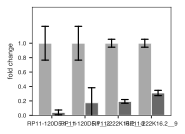

In [27]:
fig = plt.figure(figsize=(2.5, 2))

ax = sns.barplot(data=vals, x="info", y="value", hue="variable", order=order, palette=pal)
ax.set_xlabel("")
ax.set_ylabel("fold change")
ax.get_legend().remove()
ax.set_ylim((0, 1.5))
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

# plot errors
xs = [-0.2, 0.2, 0.8, 1.2, 1.8, 2.2, 2.8, 3.2]
c = 0
for i, x in enumerate(xs):
    if i % 2 == 0:
        name = order[c]
        c += 1
    subvals = vals[vals["info"] == name]
    subyerrs = yerrs[yerrs["info"] == name]
    if i % 2 == 0: #scrambled sgRNA
        val_ = subvals[subvals["type"] == "scramble"]["value"].iloc[0]
        yerr_ = subyerrs[subyerrs["type"] == "scramble"]["value"].iloc[0]
    else:
        val_ = subvals[subvals["type"] == "sgRNA"]["value"].iloc[0]
        yerr_ = subyerrs[subyerrs["type"] == "sgRNA"]["value"].iloc[0]
    ax.plot([x, x], [val_ - yerr_, val_ + yerr_], color="black")
    ax.plot([x-0.1, x+0.1], [val_ - yerr_, val_ - yerr_], color="black")
    ax.plot([x-0.1, x+0.1], [val_ + yerr_, val_ + yerr_], color="black")
    
fig.savefig("Fig4C.pdf", dpi="figure", bbox_inches="tight")

## 7. join all data, incl rt-qpcr

In [28]:
tmp1 = plot_df[plot_df["variable"].isin(["scrm_val", "scrm_yerr1", 
                                         "sgrna_val", "sgrna_yerr1"])][["info", "variable", "value"]]
tmp1 = tmp1.pivot(index="info", columns="variable").reset_index()
tmp1

info    value                                 
variable                   scrm_val scrm_yerr1 sgrna_val sgrna_yerr1
0                 EOMES__1      1.0   0.122592  0.211686    0.011610
1                EOMES__10      1.0   0.056404  0.504642    0.058451
2          RP11-120D5.1__1      1.0   0.234352  0.040950    0.033197
3          RP11-120D5.1__2      1.0   0.234352  0.173539    0.208916
4         RP11-222K16.2__3      1.0   0.054843  0.192999    0.026079
5         RP11-222K16.2__9      1.0   0.054843  0.309927    0.036625
6                 SOX17__1      1.0   0.030124  0.071298    0.006562
7                 SOX17__4      1.0   0.107328  0.103187    0.014963

In [29]:
genes = [x for x in val_data.gene_name.unique() if x not in ["SOX17", "EOMES", "RP11-120D5.1", "RP11-222K16.2"]]
rem_plot_df = pd.DataFrame()

for key in qpcr_dict:
    gene = key.split("__")[0]
    if gene in genes:
        df = qpcr_dict[key]
        df["info"] = key
        rem_plot_df = rem_plot_df.append(df)
rem_plot_df.head()

,gene,variable,value,type,info
0,PVT1,scrm_val,1.000000,scramble,PVT1__2
1,PVT1,scrm_yerr1,0.099424,scramble,PVT1__2
2,PVT1,scrm_yerr2,0.099424,scramble,PVT1__2
3,PVT1,sgrna_val,0.263036,sgRNA,PVT1__2
4,PVT1,sgrna_yerr1,0.097449,sgRNA,PVT1__2


In [30]:
tmp2 = rem_plot_df[rem_plot_df["variable"].isin(["scrm_val", "scrm_yerr1", 
                                                 "sgrna_val", "sgrna_yerr1"])][["info", "variable", "value"]]
tmp2 = tmp2.pivot(index="info", columns="variable").reset_index()
tmp2

info    value                                 
variable                  scrm_val scrm_yerr1 sgrna_val sgrna_yerr1
0           ACVR2B-AS1__6      1.0   0.194374  0.506980    0.100010
1           ACVR2B-AS1__8      1.0   0.194374  0.553504    0.213292
2                DIGIT__8      1.0   0.080243  0.100134    0.027577
3                FOXA2__1      1.0   0.034049  0.097621    0.006136
4                FOXA2__5      1.0   0.111688  0.073812    0.010502
5                GATA6__1      1.0   0.123753  0.539614    0.026357
6                GATA6__5      1.0   0.116883  0.373712    0.023067
7         KB-1440D3.14__9      1.0   0.298047  0.604298    0.083628
8            LINC00479__3      1.0   0.113193  0.547147    0.066948
9                 PVT1__1      1.0   0.179910  0.038296    0.007248
10                PVT1__2      1.0   0.099424  0.263036    0.097449
11                PVT1__6      1.0   0.110760  0.046284    0.006127
12                PVT1__9      1.0   0.110760  0.034039    0.004079
13        RP11-23F23.2__6      1.0   0.123599  0.110593    0.026408
14        RP3-508I15.9__1      1.0   0.121264  0.403321    0.046253
15        RP3-508I15.9__2      1.0   0.098210  0.422396    0.053275

In [31]:
qpcr_df = tmp1.append(tmp2)
qpcr_df["gene_name"] = qpcr_df["info"].str.split("__", expand=True)[0]
qpcr_df["guide_num"] = qpcr_df["info"].str.split("__", expand=True)[1].astype(int)

In [32]:
val_data = val_data.merge(qpcr_df, how="left", on=["gene_name", "guide_num"])
val_data.head()

,gene_name,guide_num,guide_sequence,guide_undiff,scram_undiff,guide_diff,scram_diff,rtqpcr_kd_level,date_facs,date_rtqpcr,...,transcript_biotype_status,hit_status,guide_undiff_enrich,scram_undiff_enrich,val_score,"(info, )","(value, scrm_val)","(value, scrm_yerr1)","(value, sgrna_val)","(value, sgrna_yerr1)"
0,ACVR2B-AS1,8,TAGAGGCGCCCCTGCGATGG,24.49,1.53,11.74,62.30,0.55,190906,190906,...,promoter_overlap,hit,2.086031,0.024559,6.408389,ACVR2B-AS1__8,1.0,0.194374,0.553504,0.213292
1,ACVR2B-AS1,6,TAGCCCGAACTCCGACCCTG,38.75,1.53,6.24,62.30,0.51,190906,190906,...,promoter_overlap,hit,6.209936,0.024559,7.982207,ACVR2B-AS1__6,1.0,0.194374,0.506980,0.100010
2,DIGIT,8,AAATCAGGCGGTGAGTACGT,23.99,1.82,23.63,59.22,0.10,190816,190829,...,promoter_overlap,hit,1.015235,0.030733,5.045888,DIGIT__8,1.0,0.080243,0.100134,0.027577
3,EOMES,10,CGCGGGCTAGTGGGTGGATG,9.68,1.65,45.46,61.37,0.50,190508,190726,...,protein_coding,hit,0.212934,0.026886,2.985477,EOMES__10,1.0,0.056404,0.504642,0.058451
4,EOMES,1,TTTGCAAAGCATGCAGTTAG,39.81,1.65,22.27,61.37,0.21,190508,190709,...,protein_coding,hit,1.787607,0.026886,6.055025,EOMES__1,1.0,0.122592,0.211686,0.011610


## 5. write updated file

In [33]:
val_data.columns

Index([                'gene_name',                 'guide_num',
                  'guide_sequence',              'guide_undiff',
                    'scram_undiff',                'guide_diff',
                      'scram_diff',           'rtqpcr_kd_level',
                       'date_facs',               'date_rtqpcr',
                 'sgRNA_l2fc_diff',                    'tss_id',
       'transcript_biotype_status',                'hit_status',
             'guide_undiff_enrich',       'scram_undiff_enrich',
                       'val_score',                ('info', ''),
             ('value', 'scrm_val'),     ('value', 'scrm_yerr1'),
            ('value', 'sgrna_val'),    ('value', 'sgrna_yerr1')],
      dtype='object')

In [34]:
val_data = val_data.iloc[:, [0, 1, 2, 8, 9, 3, 4, 5, 6, 10, 16, 13, 20, 21, 18, 19]]
val_data.columns = ["gene_name", "sgRNA_num", "sgRNA", "FACS_date", "RTqPCR_date", "sgRNA_FACS_pUndiff",
                    "scrambled_FACS_pUndiff", "sgRNA_FACS_pDiff", "scrambled_FACS_pDiff", "sgRNA_screen_l2fc",
                    "sgRNA_validation_score", "screen_hit_status", "sgRNA_RTqPCR_mean", "sgRNA_RTqPCR_error",
                    "scrambled_RTqPCR_mean", "scrambled_RTqPCR_error"]
val_data.head()

,gene_name,sgRNA_num,sgRNA,FACS_date,RTqPCR_date,sgRNA_FACS_pUndiff,scrambled_FACS_pUndiff,sgRNA_FACS_pDiff,scrambled_FACS_pDiff,sgRNA_screen_l2fc,sgRNA_validation_score,screen_hit_status,sgRNA_RTqPCR_mean,sgRNA_RTqPCR_error,scrambled_RTqPCR_mean,scrambled_RTqPCR_error
0,ACVR2B-AS1,8,TAGAGGCGCCCCTGCGATGG,190906,190906,24.49,1.53,11.74,62.30,2.122182,6.408389,hit,0.553504,0.213292,1.0,0.194374
1,ACVR2B-AS1,6,TAGCCCGAACTCCGACCCTG,190906,190906,38.75,1.53,6.24,62.30,3.111562,7.982207,hit,0.506980,0.100010,1.0,0.194374
2,DIGIT,8,AAATCAGGCGGTGAGTACGT,190816,190829,23.99,1.82,23.63,59.22,2.659813,5.045888,hit,0.100134,0.027577,1.0,0.080243
3,EOMES,10,CGCGGGCTAGTGGGTGGATG,190508,190726,9.68,1.65,45.46,61.37,6.092888,2.985477,hit,0.504642,0.058451,1.0,0.056404
4,EOMES,1,TTTGCAAAGCATGCAGTTAG,190508,190709,39.81,1.65,22.27,61.37,7.673196,6.055025,hit,0.211686,0.011610,1.0,0.122592


In [35]:
# update sgRNA numbers so they reflect what's in the corr plot
gene_order = ["SOX17", "EOMES", "RP11-120D5.1", "RP11-222K16.2", "FOXA2", "GATA6", 'ACVR2B-AS1', 'DIGIT', 
              'KB-1440D3.14', 'LINC00479', 'PVT1', 'RP11-23F23.2', 'RP3-508I15.9']
gene_order_df = pd.DataFrame(gene_order).reset_index()
gene_order_df.columns = ["rank", "gene_name"]
gene_order_df

,rank,gene_name
0,0,SOX17
1,1,EOMES
2,2,RP11-120D5.1
3,3,RP11-222K16.2
4,4,FOXA2
5,5,GATA6
6,6,ACVR2B-AS1
7,7,DIGIT
8,8,KB-1440D3.14
9,9,LINC00479


In [36]:
val_data = val_data.merge(gene_order_df, on="gene_name")
val_data = val_data.sort_values(by=["rank", "sgRNA_num"], ascending=True)

In [37]:
val_data.reset_index(inplace=True)
val_data.reset_index(inplace=True)
val_data["sgRNA_num"] = val_data["level_0"] + 1
val_data.drop(["level_0", "index", "rank"], axis=1, inplace=True)
val_data

,gene_name,sgRNA_num,sgRNA,FACS_date,RTqPCR_date,sgRNA_FACS_pUndiff,scrambled_FACS_pUndiff,sgRNA_FACS_pDiff,scrambled_FACS_pDiff,sgRNA_screen_l2fc,sgRNA_validation_score,screen_hit_status,sgRNA_RTqPCR_mean,sgRNA_RTqPCR_error,scrambled_RTqPCR_mean,scrambled_RTqPCR_error
0,SOX17,1,TCTGGTCTACAGCGTACCCA,190325,190326,81.23,1.48,0.06,60.59,4.184167,15.758245,hit,0.071298,0.006562,1.0,0.030124
1,SOX17,2,GCTGTAGACCAGACCGCGAC,190508,190709,82.26,1.65,8.55,61.37,7.742054,8.483190,hit,0.103187,0.014963,1.0,0.107328
2,EOMES,3,TTTGCAAAGCATGCAGTTAG,190508,190709,39.81,1.65,22.27,61.37,7.673196,6.055025,hit,0.211686,0.011610,1.0,0.122592
3,EOMES,4,CGCGGGCTAGTGGGTGGATG,190508,190726,9.68,1.65,45.46,61.37,6.092888,2.985477,hit,0.504642,0.058451,1.0,0.056404
4,RP11-120D5.1,5,GGGAAGGTTGTCTGCTCCAG,190906,190906,49.19,1.53,3.88,62.30,3.987592,9.011865,hit,0.040950,0.033197,1.0,0.234352
5,RP11-120D5.1,6,ATAGTAGAGCTCTTCACTCT,190906,190906,26.54,1.53,3.90,62.30,4.142174,8.114251,hit,0.173539,0.208916,1.0,0.234352
6,RP11-222K16.2,7,TGTCTTGAAAAGAATGTCGG,190325,190326,1.49,1.48,38.45,60.59,1.793723,0.665811,hit,0.192999,0.026079,1.0,0.054843
7,RP11-222K16.2,8,GAGCTGTCGAAATCTCCGCG,190325,190326,1.27,1.48,24.01,60.59,2.670349,1.114676,hit,0.309927,0.036625,1.0,0.054843
8,FOXA2,9,CAGGCCAGCGCCCCGCGGTA,190508,190709,3.41,1.65,8.41,61.37,3.446762,3.914662,hit,0.073812,0.010502,1.0,0.111688
9,GATA6,10,ACCCACAGCCTGGCACCCTT,190508,190709,50.85,1.65,19.22,61.37,3.470493,6.620635,hit,0.373712,0.023067,1.0,0.116883


In [38]:
val_data.to_csv("../../../data/02__screen/03__validation_data/SuppTable_S4.validation_results.txt", sep="\t",
               index=False)